In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy

# Problem 3. Lyapunov Function

In [3]:
def u(y):
    x1, x2 = y[0], y[1]
    return -2 * x1**2 * x2 #+ x2 - x1**2

def rhs(t, y, u_f):
    assert(len(y) == 2)
    x1 = y[0]
    x2 = y[1]
    return np.array([x1 * x2, -x2 + u_f(y)])
    

In [4]:
t0 = 0
t1 = 5
y0 = np.array([2, 2])

sol = solve_ivp(rhs, (t0, t1), y0, args=(u,))

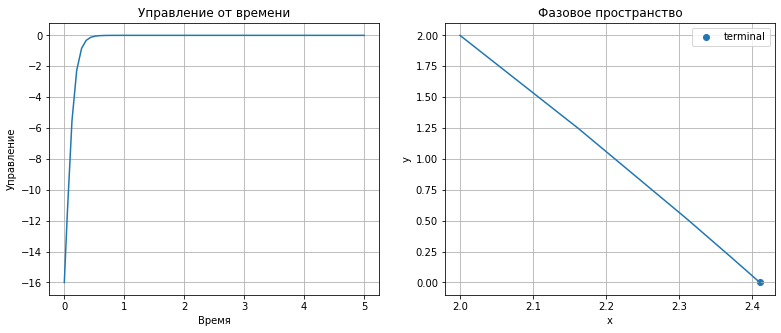

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
ax[0].plot(sol.t, u(sol.y))
# ax[1].plot(sol.t, sol.y[1, :])
ax[1].plot(sol.y[0, :], sol.y[1, :])
ax[1].scatter(sol.y[0, -1], sol.y[1, -1], label="terminal")

ax[0].grid()
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Управление")
ax[0].set_title("Управление от времени")

ax[1].grid()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Фазовое пространство")
ax[1].legend()

# Problem 4. Backstepping

In [6]:
def u(y):
    x1, x2, x3 = y[0], y[1], y[2]
    return -(2*x1*x3 + (1 + 2*x1*(2*x1 - 3*x1**2) + 2*(x1**2 - x1**3 + x2)) * (x1**2 - x1**3 + x2) + (x2 + x1**2))

def rhs(t, y, u_f):
    assert(len(y) == 3)
    x1, x2, x3 = y[0], y[1], y[2]
    return np.array([x1**2 - x1**3 + x2, x3, u_f(y)])

In [7]:
t0 = 0
t1 = 1000
y0 = np.array([1, 1, 1])

sol = solve_ivp(rhs, (t0, t1), y0, args=(u,))


No handles with labels found to put in legend.


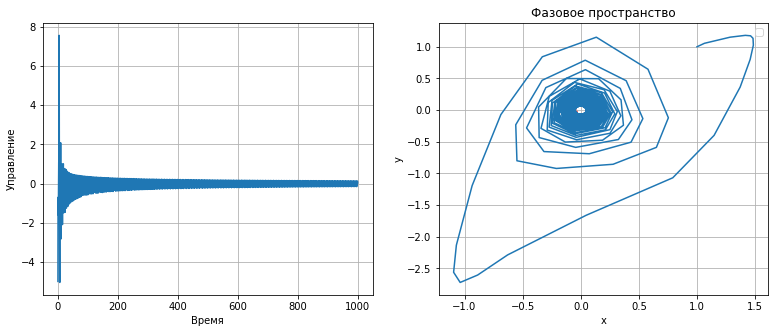

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))

ax[0].grid()
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Управление")
ax[0].plot(sol.t, u(sol.y))

ax[1].grid()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Фазовое пространство")
ax[1].scatter([sol.y[0, -1]], [sol.y[1, -1]], color='r', s=10, label="terminal")
ax[1].plot(sol.y[0, :], sol.y[1, :])
ax[1].legend()

# Problem 5. Feedback Linearization

In [9]:
def u(y, yd_f, yd_f_der, k = 5):
    assert(len(y) == 3)
    x1, x2, x3 = y[0], y[1], y[2]
    xd = yd_f(x3)
    xd_der = yd_f_der(x3)
    xd1, xd2 = xd[0], xd[1] 
    xd1_der, xd2_der = xd_der[0], xd_der[1]
    return -(k/2 * ((x1 - xd1)**2 + (x2 - xd2)**2) + (x1 - xd1) * np.sin(x2) + (x2 - xd2) * x1**4 * np.cos(x2) + (-(x1 - xd1)*xd1_der - (x2 - xd2)*xd2_der)) / (x2 - xd2)

def rhs(t, y, u_f, yd_f, yd_f_der):
    assert(len(y) == 3)
    x1, x2, x3 = y[0], y[1], y[2]
    return np.array([np.sin(x2), x1**4 * np.cos(x2) + u_f(y, yd_f, yd_f_der), 1])

In [10]:
def yd_f(t):
    return np.array([np.sin(t), np.cos(t), t])

def yd_f_der(t):
    return np.array([np.cos(t), -np.sin(t), 1])

def h(y):
    t = y[2]
    return np.linalg.norm(y - yd_f(t))
    
t0 = 0
t1 = 50

y0 = np.array([0, 2, 0])

sol = solve_ivp(rhs, (t0, t1), y0, args=(u, yd_f, yd_f_der,))

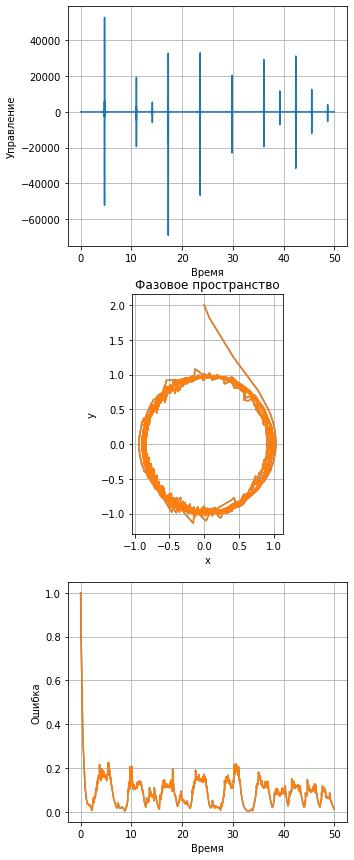

In [11]:
fig, ax = plt.subplots(3, figsize=(5, 15))

ax[1].plot(sol.y[0, :], sol.y[1, :])
ax[2].plot(sol.t, [h(i) for i in np.transpose(sol.y)])

ax[0].grid()
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Управление")
ax[0].plot(sol.t, [u(i, yd_f, yd_f_der) for i in np.transpose(sol.y)])

ax[1].grid()
ax[1].set_title("Фазовое пространство")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].plot(sol.y[0, :], sol.y[1, :])
ax[1].set_aspect('equal')

ax[2].grid()
ax[2].set_xlabel("Время")
ax[2].set_ylabel("Ошибка")
ax[2].plot(sol.t, [h(i) for i in np.transpose(sol.y)])

# Problem 6. Sliding Mode

# Problem 7. State-Dependent Riccati Equation

In [80]:
def sdre(A, B, Q, R):
    P = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R) * (B.T * P))
    return K

def u(y, Q, R):
    assert(len(y) == 2)
    x1, x2 = y[0], y[1]
    A = np.array([[-1, x1*x2], [0, -1]])
    B = np.array([[0], [x1]])
    K = sdre(A, B, Q, R)
    return -K.dot(y).item()
    
def rhs(t, y, u, Q, R):
    assert(len(y) == 2)
    x1, x2 = y[0], y[1]
    return np.array([-x1 + x1 * x2 ** 2, -x2 + x1 * u(y, Q, R)])

In [81]:
t0 = 0
t1 = 10
y0 = np.array([1, 2])

Q = np.array([[4, 0], [0, 4]])
R = np.array([[1]])

sol = solve_ivp(rhs, (t0, t1), y0, args=(u, Q, R,))

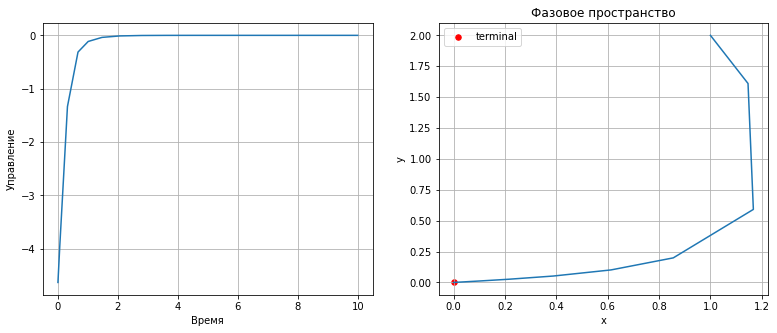

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))

ax[0].grid()
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Управление")
ax[0].plot(sol.t, [u(i, Q, R) for i in np.transpose(sol.y)])

ax[1].grid()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Фазовое пространство")
ax[1].scatter([sol.y[0, -1]], [sol.y[1, -1]], color='r', s=30, label="terminal")
ax[1].plot(sol.y[0, :], sol.y[1, :])
ax[1].legend()


# Problem 8. Model Predictive Control

In [54]:
def rhs(t, y, u = 0):
    assert(len(y) == 4)
    x1, x2, x3, x4 = y[0], y[1], y[2], y[3]
    return np.array([x2, 9.81 * np.sin(x1) - 0.1*x2 + u*np.cos(x1), x4, u])

class Parameters(object):
    pass

def cost_function(u_mpc, init_state, sim_params):
    states = np.zeros((len(u_mpc) + 1, len(init_state)))
    states[0, :] = init_state

    # интегрирование
    for k in range(len(u_mpc)):
        ts = (0, sim_params.step)
        sol = solve_ivp(lambda t, x: rhs(t, x, u_mpc[k]), ts, states[k])
        states[k + 1] = np.transpose(sol.y)[-1]

    cost = np.sum(10 * states[:, 0]**2 + states[:, 1]**2 + states[:, 2]**2 + states[:, 3]**2) + np.sum(0.01 * u_mpc**2)

    return cost
    

In [72]:
sim = Parameters()
sim.time = 10
sim.step = 0.15
sim.t = np.arange(0, sim.time, sim.step)
sim.loop_count = len(sim.t)
sim.output = False

cnst = Parameters()
cnst.u_max = 10

mpc = Parameters()
mpc.p_horizon = 2           # горизонт прогноза

c1 = ({'type':'ineq', 'fun': lambda u: -np.abs(u) + cnst.u_max})
cons = [c1]

# plot_results(sim.t, sim_states, u, cnst)

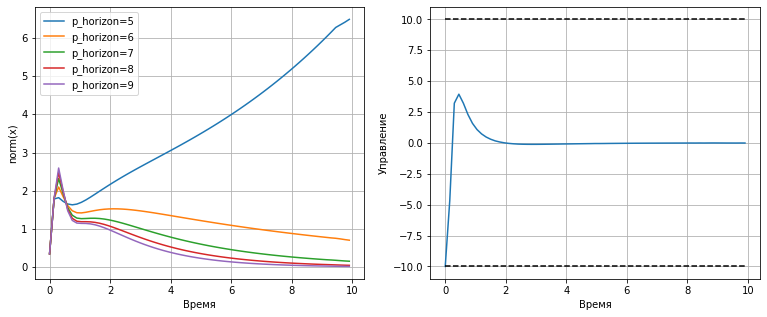

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))

for j in range(5, 10):
    mpc.p_horizon = j
    u = np.zeros(sim.loop_count) # итоговое управление
    u_optimized = np.zeros(mpc.p_horizon) # предполагаемое управление на горизонте
    states = np.zeros((sim.loop_count + 1, 4)) # состояния

    states[0, :] = np.array([np.pi * 20 / 180, 0, 0, 0]) # начальное состояние
    
    for i in range(sim.loop_count):
        # решаем оптимизационную задачу
        u_optimized = np.roll(u_optimized, -1)
        u_optimized = u_optimized[:min(mpc.p_horizon, sim.loop_count - i)]

        solution = scipy.optimize.minimize(cost_function, u_optimized, args=(states[i], sim), method='SLSQP', constraints=cons)
        u_optimized = solution.x

        u[i] = u_optimized[0]

        # интегрируем с оптимальным управлением
        ts = (sim.step * i, sim.step * (i + 1))
        sol = solve_ivp(lambda t, x: rhs(t, x, u[i]), ts, states[i])
        states[i + 1, :] = np.transpose(sol.y)[-1]
    ax[0].plot(sim.t, [np.linalg.norm(k) for k in states[:-1]], label=f'p_horizon={j}')
    
    
ax[0].set_xlabel("Время")
ax[0].set_ylabel("norm(x)")
ax[0].grid()
ax[0].legend()

ax[1].plot(sim.t, u)
control_upper_bound = np.ones(np.size(sim.t)) * cnst.u_max
control_lower_bound = -control_upper_bound
ax[1].plot(sim.t, control_upper_bound, linestyle = '--', color = 'black')
ax[1].plot(sim.t, control_lower_bound, linestyle = '--', color = 'black')
ax[1].grid()
ax[1].set_xlabel("Время")
ax[1].set_ylabel("Управление")

plt.show()
